In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
# Importing libraries
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping
import keras.utils
from keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Model

In [169]:
num_classes = 5
input_shape = (100, 100, 3) # Previously known from inspection of images

SEED = 42
BATCH_SIZE = 32
# Update DATA_DIR and CSV_FILE to point to the location in your Google Drive
DATA_DIR = '/content/drive/MyDrive/Task_3/Dataset_CSC300_Assignment_3_ml_cnn/Datasets'
CSV_FILE = '/content/drive/MyDrive/Task_3/Dataset_CSC300_Assignment_3_ml_cnn/labels.csv'


# Setting session seeds for reproducability
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [170]:
# Loading data
# Loading labels in CSV folder
try:
    # Read and shuffle data
    df = pd.read_csv(CSV_FILE).sample(frac=1, random_state=SEED).reset_index(drop=True)
except FileNotFoundError:
    print(f"Error: Unable to find CSV file 'labels.csv' at {CSV_FILE}. Ensure file is in location/ path is correct.")

# Removing /spectrograms as it is not apart of the file structure
df['image_path'] = df['image_path'].str.replace(r'^spectrograms', DATA_DIR, regex=True)

# Converting labels into integer values so that classification model would work
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['class_label'])
df

,image_path,class_label,encoded_labels
0,/content/drive/MyDrive/Task_3/Dataset_CSC300_A...,class_d,3
1,/content/drive/MyDrive/Task_3/Dataset_CSC300_A...,class_d,3
2,/content/drive/MyDrive/Task_3/Dataset_CSC300_A...,class_a,0
3,/content/drive/MyDrive/Task_3/Dataset_CSC300_A...,class_e,4
4,/content/drive/MyDrive/Task_3/Dataset_CSC300_A...,class_e,4
...,...,...,...
2495,/content/drive/MyDrive/Task_3/Dataset_CSC300_A...,class_c,2
2496,/content/drive/MyDrive/Task_3/Dataset_CSC300_A...,class_a,0
2497,/content/drive/MyDrive/Task_3/Dataset_CSC300_A...,class_a,0
2498,/content/drive/MyDrive/Task_3/Dataset_CSC300_A...,class_c,2


In [171]:
# Checking image sizes of the images, also checks how many images with different image sizes
from PIL import Image

df['dimensions'] = df['image_path'].apply(lambda x: Image.open(x).size)
print(df['dimensions'].value_counts())
df = df.drop(columns="dimensions")

KeyboardInterrupt: 

In [172]:
# Getting sizes for each dataset split based on percentages
total = len(df)
train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size

# Split into training, validation, testing dataframes (splitting up data)
training_df = df[:train_size]

val_df = df[train_size:train_size + val_size]

test_df = df[train_size + val_size:]

In [173]:
# Function to load images in using labels.csv
def process_image(image_path, class_label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    # Explicitly set the shape of the image tensor
    image.set_shape(input_shape)
    # Scalling image so values fall between 0-1
    image = tf.cast(image, tf.float32) / 255.0 # Casting as a precautionary measure
    return image, class_label



In [174]:
# Building a tf.data.Dataset with our images
def build_dataset(df, batch_size=32):
    # Getting paths to images and associated class
    paths = df['image_path'].values
    labels = df['encoded_labels'].values
    # Creates a tensorflow object with our values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(lambda x, y: process_image(x, y), num_parallel_calls=tf.data.AUTOTUNE) # AUTOTUNE allows multithreading for this transformation step
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE) # Allows multithreading & batches, used for efficiency


In [175]:
# Applying functions to get 3 datasets
train_ds = build_dataset(training_df, batch_size=BATCH_SIZE)
val_ds = build_dataset(val_df, batch_size=BATCH_SIZE)
test_dataset = build_dataset(test_df, batch_size=BATCH_SIZE)

In [176]:
# Used to test whether data was loaded correctly with the correct measurements for each batch
for image_batch, label_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)

Image batch shape: (32, 100, 100, 3)
Label batch shape: (32,)


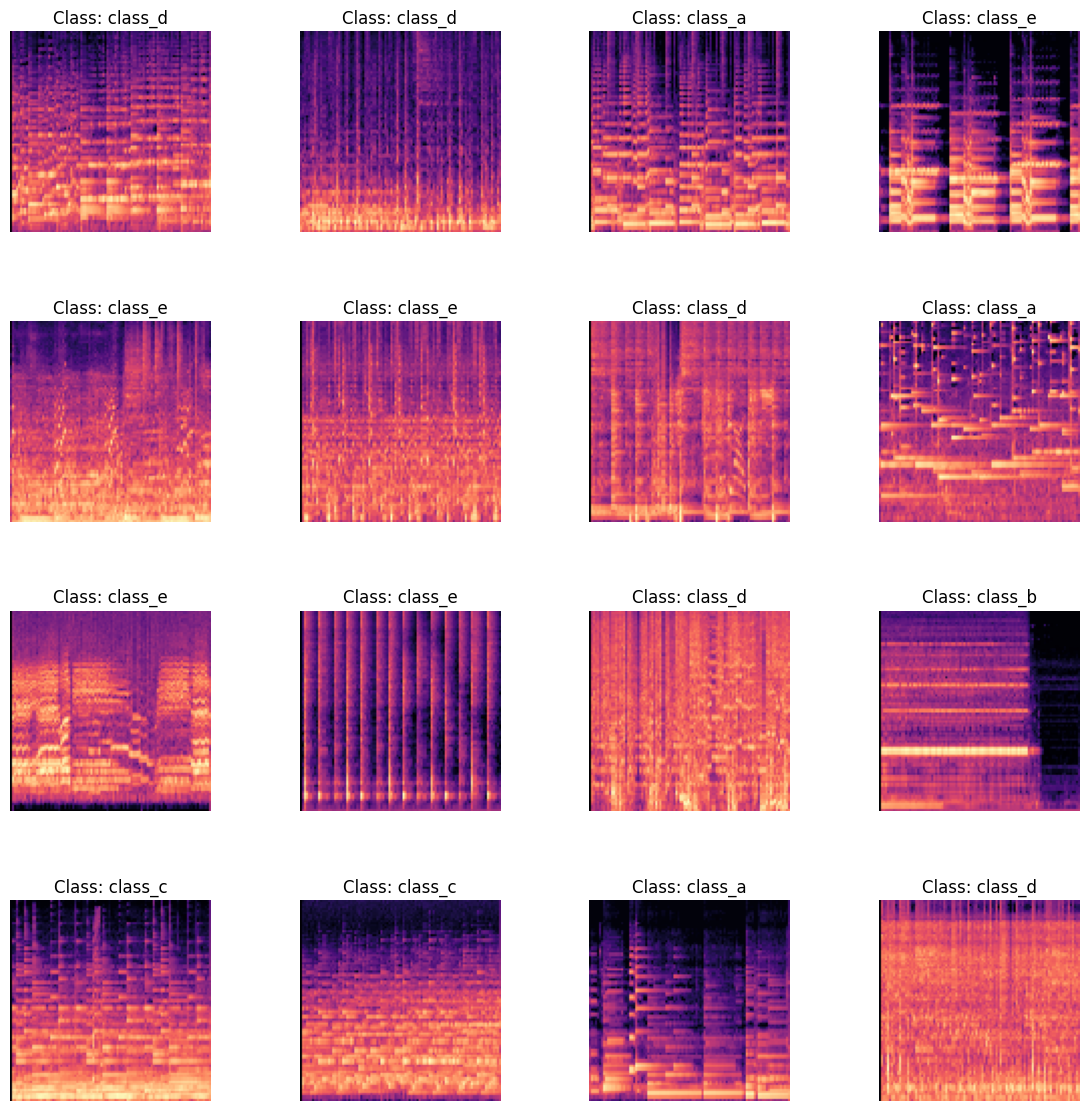

In [177]:
# Plotting images to better understand what the image dataset contains
# Also since we have 5 classes we can see an image from each class
for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()

    class_names = label_encoder.inverse_transform(labels)  # Convert to class names

    fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))
    fig.tight_layout(pad=3.0)
    for j in range(4):
        for i in range(4):
            idx = j * 4 + i
            ax[j][i].imshow(images[idx])
            ax[j][i].axis('off')
            ax[j][i].set_title(f"Class: {class_names[idx]}")


(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600')])

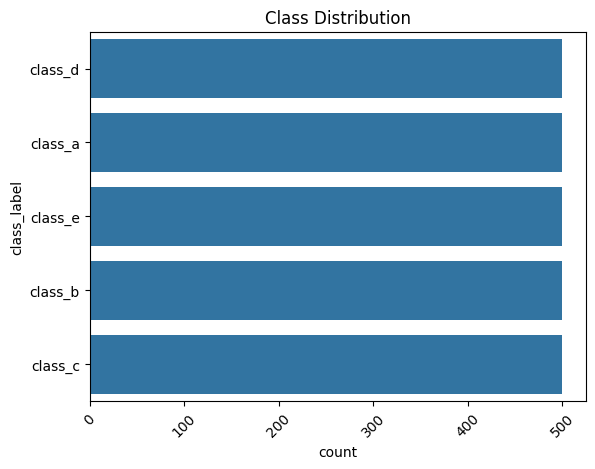

In [178]:
# Counts the number of images in each class in order to ensure we have enough data in each
# class for accurate results and to avoid overfitting
sns.countplot(df['class_label'])
plt.title("Class Distribution")
plt.xticks(rotation=45)

In [179]:
# Creating a CNN network
# THIS IS THE FINAL MODEL TO BE USED, YIELDS BEST RESULTS WITH SMALLEST AMOUNT OF TRAINING TIME
model_1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# BEST MODEL, YET MOST COMPUTATIONALY AND TIME HEAVY
# model_1 = keras.Sequential(
#     [
#         keras.Input(shape=input_shape),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
#         layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(256, activation="relu"),
#         layers.Dense(num_classes, activation="softmax"),
#     ]
# )

# GOOD FOR SPEED BUT AS LOWEST ACCURACY READINGS
# model_1 = keras.Sequential(
#     [
#         keras.Input(shape=input_shape),
#         layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
#         layers.MaxPooling2D(pool_size=(2, 2)),

#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(256, activation="relu"),
#         layers.Dense(num_classes, activation="softmax"),
#     ]
# )

In [180]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 858,597 (3.28 MB)

 Trainable params: 858,597 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

In [181]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [182]:
# Declaring variables
batch_size = 128
epochs = 15
# Ressetting the session so that no data from keras is left in memory
K.clear_session()
tf.compat.v1.reset_default_graph()


# Used for early stopping, to stop the model from training once minimal performance enhancements are noticed, prevents overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
)

# Compilling the model with performance metrics and loss functions
model_1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Actual training of the model based on our training data
history = model_1.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=epochs, callbacks=early_stop)


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.1964 - loss: 1.6141 - val_accuracy: 0.2747 - val_loss: 1.5518
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.3194 - loss: 1.5374 - val_accuracy: 0.3013 - val_loss: 1.5284
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.3590 - loss: 1.5005 - val_accuracy: 0.3627 - val_loss: 1.5081
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.3980 - loss: 1.4681 - val_accuracy: 0.3680 - val_loss: 1.5232
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.3991 - loss: 1.4470 - val_accuracy: 0.3893 - val_loss: 1.4404
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.4457 - loss: 1.3875 - val_accuracy: 0.3760 - val_loss: 1.4436
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.4562 - loss: 1.3644 - val_accuracy: 0.4133 - val_loss: 1.4191
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.4702 - loss: 1.3334 - val_accurac

In [183]:
# Testing the model against our test dataset
score = model_1.evaluate(test_dataset, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.314780592918396
Test accuracy: 0.5093333125114441


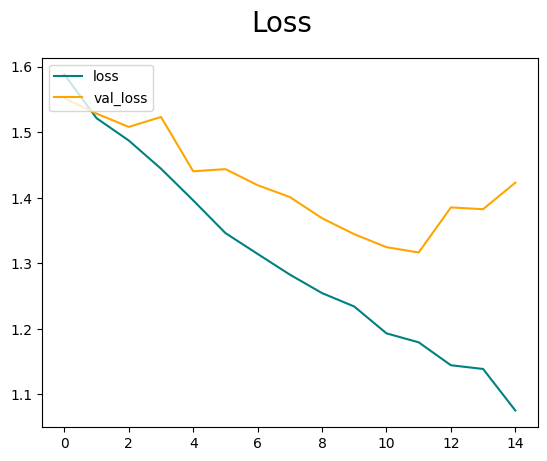

In [184]:
# Used to plot the training loss and validation loss to determine if overfitting it taking place
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

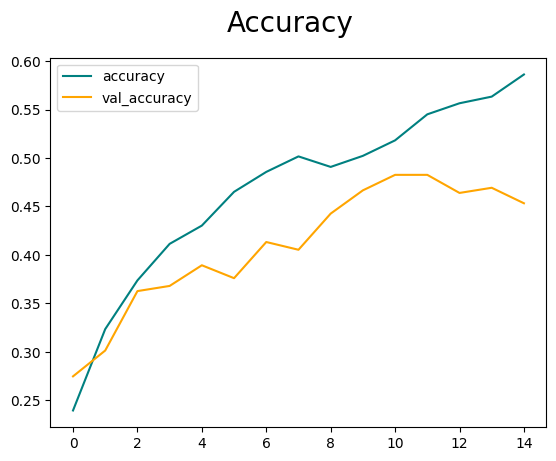

In [185]:
# Used to plot the training and validation accuracy to determine how well the model is performing each itteration
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [122]:
# Reloading of dataset, due to mismatch of size of images (EfficientNetB0 needs (224, 224, 3) images)
efficientnet_image_size = (224, 224)
BATCH_SIZE = 32
num_classes = 5
efficientnet_input_shape = (224, 224, 3) # Previously known from inspection of images

# Update DATA_DIR and CSV_FILE to point to the location in your Google Drive
DATA_DIR = '/content/drive/MyDrive/Task_3/Dataset_CSC300_Assignment_3_ml_cnn/Datasets'
CSV_FILE = '/content/drive/MyDrive/Task_3/Dataset_CSC300_Assignment_3_ml_cnn/labels.csv'

In [123]:
# Data augmentation pipeline to prevent overfitting in the model
# I did mention not applying any data augmentation it was added as an experiment to help generalise the data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [124]:
label_encoder_2 = LabelEncoder()

# Loading data images from directory folders
image_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    seed=SEED,
    image_size=efficientnet_image_size,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Get the total number of batches
num_batches = tf.data.experimental.cardinality(image_ds).numpy()

# Split ratio
train_size = int(0.7 * num_batches)
val_size = int(0.15 * num_batches)
test_size = num_batches - train_size - val_size

# Splitting of dataset based on ratios
efficientnet_train_ds = image_ds.take(train_size)
remainder = image_ds.skip(train_size)
efficientnet_val_ds = remainder.take(val_size)
efficientnet_test_ds = remainder.skip(test_size)

# Let tensorflow decide optimal buffer size for prefetching data for next batches durring preprocessing
AUTOTUNE = tf.data.AUTOTUNE
efficientnet_train_ds = efficientnet_train_ds.prefetch(buffer_size=AUTOTUNE)
efficientnet_val_ds = efficientnet_val_ds.prefetch(buffer_size=AUTOTUNE)
efficientnet_test_ds = efficientnet_test_ds.prefetch(buffer_size=AUTOTUNE)

Found 2500 files belonging to 5 classes.


In [125]:
# Applying EfficientNetB0 preprocessing module
def apply_efficientnet_train_preprocessing(image, label):
    image = tf.cast(image, tf.float32) # safety check incase images are not output as float32
    image = preprocess_input(image)
    image = preprocess_input(image)
    image = data_augmentation(image)
    return image, label

In [126]:
# Applying EfficientNetB0 preprocessing module to each element in the 3 datasets
efficientnet_train_ds = efficientnet_train_ds.map(apply_efficientnet_train_preprocessing).prefetch(buffer_size=AUTOTUNE)
efficientnet_val_ds = efficientnet_val_ds.map(apply_efficientnet_train_preprocessing).prefetch(buffer_size=AUTOTUNE)
efficientnet_test_ds = efficientnet_test_ds.map(apply_efficientnet_train_preprocessing).prefetch(buffer_size=AUTOTUNE)

In [127]:
# Verify dataset
for images, labels in efficientnet_train_ds.take(1):
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)

Batch shape: (32, 224, 224, 3)
Labels shape: (32,)


In [128]:
# Downloading the InceptionV3 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=efficientnet_input_shape)

In [129]:
# To view each layer in the EfficientNetB0 model
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_3          33: block2b_expand_bn      66: block3b_activation     99: block4b_se_expand     
  1: rescaling_4            34: block2b_expand_activation 67: block3b_se_squeeze    100: block4b_se_excite     
  2: normalization_2        35: block2b_dwconv         68: block3b_se_reshape    101: block4b_project_conv  
  3: rescaling_5            36: block2b_bn             69: block3b_se_reduce     102: block4b_project_bn    
  4: stem_conv_pad          37: block2b_activation     70: block3b_se_expand     103: block4b_drop          
  5: stem_conv              38: block2b_se_squeeze     71: block3b_se_excite     104: block4b_add           
  6: stem_bn                39: block2b_se_reshape     72: block3b_project_conv  105: block4c_expand_conv   
  7: stem_activation        40: block2b_se_reduce      73: block3b_project_bn    106: block4c_expand_bn     
  8: block1a_dwconv         41: block2b_se_expand      74: block3b_drop          107: block4c_expand_activation
  9: block1a_

In [130]:
# Freeze the weights for each layer of the base model prevent updating large pre-trained weights during initial training
base_model.trainable = False

In [131]:
# # Reduce spatial dimensions to 1x1 for dense layer
# avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# # Added Dense layer for feature extraction
# dense_1 = tf.keras.layers.Dense(units=256, activation='relu')(avg)
# # Added dropout to prevent overfitting and add regularization
# drop = tf.keras.layers.Dropout(0.5)(dense_1)
# # Output layer for transfer learnt model
# output = tf.keras.layers.Dense(num_classes, activation="softmax")(drop)
# # Creation of full model
# model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Reduce spatial dimensions to 1x1 for dense layer
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# Added Dense layer for feature extraction and maxpooling for size reduction
dense_1 = tf.keras.layers.Dense(units=16, activation='relu')(avg)
dense_2 = tf.keras.layers.Dense(units=32, activation='relu')(dense_1)
dense_3 = tf.keras.layers.Dense(units=16, activation='relu')(dense_2)
# Added dropout to prevent overfitting and add regularization
drop = tf.keras.layers.Dropout(0.5)(dense_3)
# Output layer for transfer learnt model
output = tf.keras.layers.Dense(num_classes, activation="softmax")(drop)
# Creation of full model
model = tf.keras.Model(inputs=base_model.input, outputs=output)


model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,071,224 (15.53 MB)

 Trainable params: 21,653 (84.58 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [132]:
# Compilling the model with metrics, loss and optimizer set
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Small learn rate for fine-tuning
              metrics=["accuracy"])

In [ ]:
# Defining call backs to prevent overfitting
# Early stopping callback (stop training when val_loss doesn't improve)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True # restore model weights from epoch with best val
)

# Used to save model checkpoints so that training is resiliant to interuptions, we can save the best model and make fine-tuning easier
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='EfficientNetB0_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', # Maximize the val_accuracy for saves
    verbose=1
)

In [134]:
# Training of models output layers that we added
history_part_1 = model.fit(
    efficientnet_train_ds,
    epochs=20,
    validation_data=efficientnet_val_ds,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.2179 - loss: 1.6173
Epoch 1: val_accuracy improved from -inf to 0.33523, saving model to inceptionv3_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 773ms/step - accuracy: 0.2183 - loss: 1.6171 - val_accuracy: 0.3352 - val_loss: 1.5711
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.2689 - loss: 1.5773
Epoch 2: val_accuracy improved from 0.33523 to 0.40057, saving model to inceptionv3_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 674ms/step - accuracy: 0.2692 - loss: 1.5771 - val_accuracy: 0.4006 - val_loss: 1.4963
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.3150 - loss: 1.5386
Epoch 3: val_accuracy did not improve from 0.40057
55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 687ms/step - accuracy: 0.3151 - loss: 1.5384 - val_accuracy: 0.3636 - val_loss: 1.4552
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.3298 - loss: 1.5024
Epoch 4: val_accuracy did not improve from 0.40057
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 655ms/step - accuracy: 0.3298 - loss: 1.5025 - val_accuracy: 0.3949 - val_loss: 1.4454
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.3269 - loss: 1.5097
Epoch 5: val_accuracy improved from 0.40057 to 0.42898, saving model to inceptionv3_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 673ms/step - accuracy: 0.3271 - loss: 1.5095 - val_accuracy: 0.4290 - val_loss: 1.4410
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.3421 - loss: 1.4951
Epoch 6: val_accuracy improved from 0.42898 to 0.46875, saving model to inceptionv3_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 679ms/step - accuracy: 0.3421 - loss: 1.4950 - val_accuracy: 0.4688 - val_loss: 1.3853
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.3760 - loss: 1.4871
Epoch 7: val_accuracy did not improve from 0.46875
55/55 ━━━━━━━━━━━━━━━━━━━━ 47s 853ms/step - accuracy: 0.3760 - loss: 1.4869 - val_accuracy: 0.4688 - val_loss: 1.3812
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.3476 - loss: 1.4755
Epoch 8: val_accuracy did not improve from 0.46875
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 654ms/step - accuracy: 0.3479 - loss: 1.4753 - val_accuracy: 0.4375 - val_loss: 1.3839
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.3970 - loss: 1.4674
Epoch 9: val_accuracy improved from 0.46875 to 0.48864, saving model to inceptionv3_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 660ms/step - accuracy: 0.3969 - loss: 1.4675 - val_accuracy: 0.4886 - val_loss: 1.3811
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.3753 - loss: 1.4578
Epoch 10: val_accuracy improved from 0.48864 to 0.51705, saving model to inceptionv3_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 678ms/step - accuracy: 0.3755 - loss: 1.4575 - val_accuracy: 0.5170 - val_loss: 1.3592
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.4101 - loss: 1.4361
Epoch 11: val_accuracy did not improve from 0.51705
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 667ms/step - accuracy: 0.4102 - loss: 1.4358 - val_accuracy: 0.4972 - val_loss: 1.3598
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.3836 - loss: 1.4555
Epoch 12: val_accuracy did not improve from 0.51705
55/55 ━━━━━━━━━━━━━━━━━━━━ 47s 858ms/step - accuracy: 0.3838 - loss: 1.4552 - val_accuracy: 0.5028 - val_loss: 1.3444
Epoch 13/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.4136 - loss: 1.4287
Epoch 13: val_accuracy did not improve from 0.51705
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 653ms/step - accuracy: 0.4136 - loss: 1.4287 - val_accuracy: 0.4943 - val_loss: 1.3327
Epoch 14/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.3968 - loss: 1.4399
Epoch 14: val_accuracy d

55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 658ms/step - accuracy: 0.4197 - loss: 1.4174 - val_accuracy: 0.5597 - val_loss: 1.2461
Epoch 17/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.4354 - loss: 1.4073
Epoch 17: val_accuracy did not improve from 0.55966
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 646ms/step - accuracy: 0.4353 - loss: 1.4071 - val_accuracy: 0.5568 - val_loss: 1.3121
Epoch 18/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4314 - loss: 1.4098
Epoch 18: val_accuracy did not improve from 0.55966
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 637ms/step - accuracy: 0.4313 - loss: 1.4096 - val_accuracy: 0.5426 - val_loss: 1.3413
Epoch 19/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.4092 - loss: 1.4157
Epoch 19: val_accuracy did not improve from 0.55966
55/55 ━━━━━━━━━━━━━━━━━━━━ 47s 859ms/step - accuracy: 0.4093 - loss: 1.4155 - val_accuracy: 0.5369 - val_loss: 1.2631
Epoch 20/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.4208 - loss: 1.4136
Epoch 20: val_accuracy d

In [135]:
# Unfreezing the model so we can tune the weights for the model to better fit our use case
# Usually good to unfreeze top layers but InceptionV3 in particular is good to unfreeze bottom layers
# Unfreeze base model
base_model.trainable=True
num_layers_base_model = len(base_model.layers)
print(num_layers_base_model)

# We want to unfreeze the top ~1/3 layers
freeze_layer_threshold = 150
for layer in base_model.layers[freeze_layer_threshold:]:
    layer.trainable=False

for layer in base_model.layers[:freeze_layer_threshold]:
    layer.trainable=True

# Recompilling so changes take place
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Very small learn rate for fine-tuning
              metrics=["accuracy"])


238


In [136]:
# Fitting of model
history_part_2 = model.fit(
    efficientnet_train_ds,
    epochs=20,
    validation_data=efficientnet_val_ds,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.2348 - loss: 1.7732
Epoch 1: val_accuracy did not improve from 0.55966
55/55 ━━━━━━━━━━━━━━━━━━━━ 102s 803ms/step - accuracy: 0.2352 - loss: 1.7712 - val_accuracy: 0.4943 - val_loss: 1.3389
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.3122 - loss: 1.5466
Epoch 2: val_accuracy did not improve from 0.55966
55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 691ms/step - accuracy: 0.3128 - loss: 1.5462 - val_accuracy: 0.4602 - val_loss: 1.3811
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.3631 - loss: 1.4921
Epoch 3: val_accuracy did not improve from 0.55966
55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 685ms/step - accuracy: 0.3633 - loss: 1.4919 - val_accuracy: 0.4460 - val_loss: 1.3674
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.3883 - loss: 1.4696
Epoch 4: val_accuracy did not improve from 0.55966
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 690ms/step - accuracy: 0.3885 - loss: 1.4691 - val_accuracy: 0.443

55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 672ms/step - accuracy: 0.4486 - loss: 1.3484 - val_accuracy: 0.5824 - val_loss: 1.1989
Epoch 13/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.4621 - loss: 1.3245
Epoch 13: val_accuracy did not improve from 0.58239
55/55 ━━━━━━━━━━━━━━━━━━━━ 48s 874ms/step - accuracy: 0.4624 - loss: 1.3243 - val_accuracy: 0.5341 - val_loss: 1.2311
Epoch 14/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.4487 - loss: 1.3432
Epoch 14: val_accuracy did not improve from 0.58239
55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 684ms/step - accuracy: 0.4489 - loss: 1.3429 - val_accuracy: 0.5540 - val_loss: 1.2443
Epoch 15/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.4559 - loss: 1.3377
Epoch 15: val_accuracy did not improve from 0.58239
55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 681ms/step - accuracy: 0.4564 - loss: 1.3371 - val_accuracy: 0.5341 - val_loss: 1.2184
Epoch 16/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.4572 - loss: 1.3368
Epoch 16: val_accuracy i

55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 703ms/step - accuracy: 0.4576 - loss: 1.3362 - val_accuracy: 0.5881 - val_loss: 1.1917
Epoch 17/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.4783 - loss: 1.3226
Epoch 17: val_accuracy did not improve from 0.58807
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 668ms/step - accuracy: 0.4785 - loss: 1.3221 - val_accuracy: 0.5767 - val_loss: 1.2174
Epoch 18/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.4983 - loss: 1.3480
Epoch 18: val_accuracy did not improve from 0.58807
55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 683ms/step - accuracy: 0.4982 - loss: 1.3472 - val_accuracy: 0.5767 - val_loss: 1.2238
Epoch 19/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.4872 - loss: 1.2918
Epoch 19: val_accuracy improved from 0.58807 to 0.61648, saving model to inceptionv3_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 699ms/step - accuracy: 0.4871 - loss: 1.2918 - val_accuracy: 0.6165 - val_loss: 1.2153
Epoch 20/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.4747 - loss: 1.3158
Epoch 20: val_accuracy did not improve from 0.61648
55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 692ms/step - accuracy: 0.4749 - loss: 1.3153 - val_accuracy: 0.6165 - val_loss: 1.1781


In [137]:
score = model.evaluate(efficientnet_test_ds, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.2199933528900146
Test accuracy: 0.595678985118866


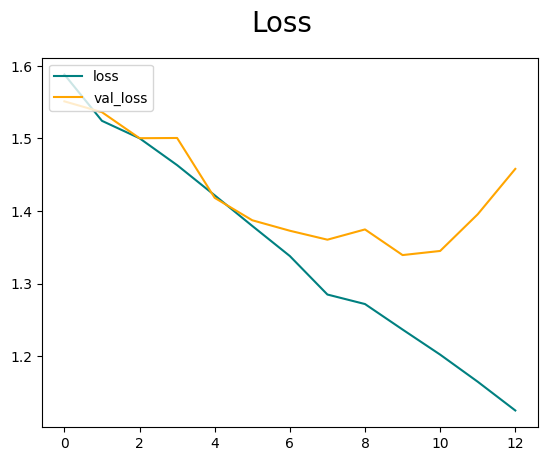

In [138]:
# Used to plot the training loss and validation loss to determine if overfitting it taking place
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

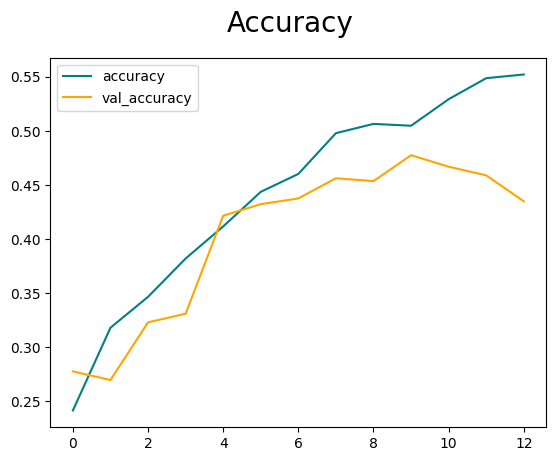

In [139]:
# Used to plot the training and validation accuracy to determine how well the model is performing each itteration
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()